# Perylene analysis

Jupyter notebook for the analysis of radial updates in the context of the perylene molecule targeted with the Hubbard model.  
Naturally, utilizing this notebook requires access to the data and the path has to be provided in the next cell.  
While this notebook should suffice to recreate all the analysis steps starting from the raw data (i.e. the files given in "PeRU/data"), actually running all of the postprocessing steps will take quite a lot of time. Therefore, the intermediate postprocessed data is already provided in "PeRU/postpro_data".  

### Specifiy glob_path to link to the data folder

In [ ]:
glob_path = ""

data_path = glob_path + "PeRU/data/"
postpro_path = glob_path + "PeRU/postpro_data/"
plot_path = glob_path + "PeRU/plots/"

### Import modules and necessary custom functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import os
import time
%matplotlib inline

from utils import save_arrays, get_NSL_lattices_from_h5, round_to_n, round_to_n_of_err, get_parentheses_error_notation, sep
from autocorrelation_funcs import single_autocorrelation_analysis, autocorrelation_analysis
from fitting import get_bootstrapped_samples, bootstrap_fit, bootstrap_fit_and_sigmin, ac_fit_f
from observable_funcs import load_comp_save_obs, mean_obs, abs_mean_obs
from PeRU_funcs import get_PeRU_correlators_from_h5, PeRU_correlator_autocorr_analysis

my_blue = (2/255, 61/255, 107/255)
my_red = (217/255, 85/255, 20/255)
my_green = (163/255, 201/255, 0/255)
cs = [my_blue, my_red, my_green]

### Define all simulations

In [4]:
sim_dict = {}

### beta = 4
tmp_dict = {}
tmp_dict["Nmd"] = 6
tmp_dict["Nconf"] = int(2e6)
tmp_dict["Nt"] = 96
tmp_dict["sigma"] = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 
                    0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 
                    0.1, 0.2, 0.3, 0.5]
sim_dict["b4"] = tmp_dict

### beta = 8
tmp_dict = {}
tmp_dict["Nmd"] = 10
tmp_dict["Nconf"] = int(2e6)
tmp_dict["Nt"] = 96
tmp_dict["sigma"] = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 
                    0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.06, 0.07, 0.08, 0.09, 
                    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sim_dict["b8"] = tmp_dict


beta_ = [4, 8]
# beta_ = [6, 4, 8]
obs_dict = {"mean" : mean_obs, 
            "absmean" : abs_mean_obs}

ac_dicts = {}

tmp_dict = {}
tmp_dict["S"] = 1.0
tmp_dict["use_zc"] = False
tmp_dict["c"] = 0.0
tmp_dict["ac_title"] = r"$S=1$"
ac_dicts["S1"] = tmp_dict

tmp_dict = {}
tmp_dict["S"] = 0.0
tmp_dict["use_zc"] = True
tmp_dict["c"] = 0.0
tmp_dict["ac_title"] = "zero-crossing"
ac_dicts["zc"] = tmp_dict

# tmp_dict = {}
# tmp_dict["S"] = 0.0
# tmp_dict["use_zc"] = False
# tmp_dict["c"] = 10.0
# tmp_dict["ac_title"] = r"$c=10$"
# ac_dicts["c10"] = tmp_dict

# Perylene Analysis

Compute and save standard observables.  
Disclaimer: This takes a lot of time and should not be done in a serial way. Feel free to rely on the already post processed data.  
DONE but double check data path after copying and adjusting filename

In [135]:
for beta in beta_:
    Nmd = sim_dict[f"b{beta}"]["Nmd"]
    Nconf_max = sim_dict[f"b{beta}"]["Nconf"]
    sig_ = sim_dict[f"b{beta}"]["sigma"]
    t1 = time.time()
    for sig in sig_:
        path = data_path + "PeRU_Nt96_s"+str(sig).replace(".", "p")+f"_Nmd{Nmd}_b{beta}p0U2p0optT.h5"
        csv_path = postpro_path + f"b{beta}/PeRU_Nt96_s"+str(sig).replace(".", "p")+f"_Nmd{Nmd}_b{beta}U2_obs.csv"
        load_comp_save_obs(path, obs_dict, Nconf_max = Nconf_max, csv_path = csv_path)
        print(time.time()-t1)

### Compute and save $\tau_{\mathrm{int}}$ for previously computed observables; DONE

In [149]:
data_head = ["sigma", "mean", "var", "stderr", "err_err", "tau_int", "dtau_int", "W"]


for beta_ind, beta in enumerate(beta_):
    Nmd = sim_dict[f"b{beta}"]["Nmd"]
    Nconf_max = sim_dict[f"b{beta}"]["Nconf"]
    sig_ = sim_dict[f"b{beta}"]["sigma"]
    data = np.zeros((len(sig_), len(ac_dicts), len(obs_dict), len(data_head)-1))
    for sig_ind, sig in enumerate(sig_):
        fname = postpro_path + f"b{beta}/PeRU_Nt96_s"+str(sig).replace(".", "p")+f"_Nmd{Nmd}_b{beta}U2_obs.csv"
        df = pd.read_csv(fname)
        loaded_data = df.to_numpy()
        for ac_ind, (ac_key, tmp_dict) in enumerate(ac_dicts.items()):
            S = tmp_dict["S"]
            use_zc = tmp_dict["use_zc"]
            c = tmp_dict["c"]
            ac_title = tmp_dict["ac_title"]
        
            data[sig_ind, ac_ind, :, 0],\
            data[sig_ind, ac_ind, :, 1],\
            data[sig_ind, ac_ind, :, 2],\
            data[sig_ind, ac_ind, :, 3],\
            data[sig_ind, ac_ind, :, 4],\
            data[sig_ind, ac_ind, :, 5],\
            data[sig_ind, ac_ind, :, 6] = autocorrelation_analysis(data = loaded_data, 
                                                                             use_fft = True, 
                                                                             S = S, 
                                                                             use_first_zero_crossing = use_zc, 
                                                                             c = c, 
                                                                             plot_results = False, 
                                                                             save_plot = plot_path + f"ac/b{beta}/PeRU_b{beta}_s"+str(sig).replace(".","p")+f"_ac_"+ac_key+".png", 
                                                                             suptitle = rf"PeRU; $\sigma_R=${sig}; "+ac_title)
        print("=================================================================================================================================================================================")
    ### Save the data
    for ac_ind, ac_key in enumerate(ac_dicts.keys()):
        for obs_ind, obs_key in enumerate(obs_dict.keys()):
            c_dict = {}
            for col_ind, col_name in enumerate(data_head):
                c_dict[col_name] = sig_ if col_ind==0 else data[:, ac_ind, obs_ind, col_ind-1]
            csv_path = postpro_path + f"b{beta}/PeRU_Nt96_Nmd{Nmd}_b{beta}U2_ac_"+ac_key+"_"+obs_key+".csv"
            df = pd.DataFrame(c_dict)
            df.to_csv(csv_path, index = False) 


### Compute and save $\tau_{\mathrm{int}}$ for single particle correlator; NOT TESTED YET AND ADJUST data path if naming has changed
This will take a lot of time and should be run in a serial way or using pre-stored correlators. Feel free to rely on the post-processed data. 

In [1]:
data_head = ["obs", "stderr", "tau_int", "dtau_int", "W"]
n_corr = 2 # Has to be either 1 or 2. The two components are mirror images so technically just considering one of the components is sufficient.

for beta_ind, beta in enumerate(beta_):
    Nmd = sim_dict[f"b{beta}"]["Nmd"]
    Nconf_max = sim_dict[f"b{beta}"]["Nconf"]
    Nt = sim_dict[f"b{beta}"]["Nt"]
    sig_ = sim_dict[f"b{beta}"]["sigma"]
    data = np.zeros((len(ac_dicts), len(sig_), Nt, n_corr, len(data_head)))
    print("Begin")
    for i, sig in enumerate(sig_):
        path = data_path + "PeRU_Nt96_s"+str(sig).replace(".", "p")+f"_Nmd{Nmd}_b{beta}p0U2p0optT_reco.h5"
        print("Start loading data")
        t1 = time.time()
        full_corr = np.real(get_PeRU_correlators_from_h5(path, Nconf_max))
        print(f"Finished loading data at {round(time.time()-t1, 2)}")
        for corr_ind in range(n_corr):
            for ac_ind, (ac_key, tmp_dict) in enumerate(ac_dicts.items()):
                S, use_zc, c, ac_title = tmp_dict["S"], tmp_dict["use_zc"], tmp_dict["c"], tmp_dict["ac_title"]
                tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_ = PeRU_correlator_autocorr_analysis(full_corr, 
                                                                                                 S = 1.0, 
                                                                                                 use_first_zero_crossing = False, 
                                                                                                 save_plot = plot_path + f"ac/b{beta}/PeRU_s"+str(sig).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_"+ac_key, 
                                                                                                 suptitle = rf"$\sigma_R = {sig}$; "+ac_title, 
                                                                                                 corr_ind = corr_ind)
                save_fname = postpro_path + f"b{beta}/PeRU_s"+str(sig).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_"+ac_key+"_test.txt"
                save_arrays(save_fname, ["obs", "stderr", "tint", "dtint", "W"], False, tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_)
                data[ac_ind, i, :, corr_ind, 0], data[ac_ind, i, :, corr_ind, 1], data[ac_ind, i, :, corr_ind, 2], data[ac_ind, i, :, corr_ind, 3], data[ac_ind, i, :, corr_ind, 4] = tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_


Reduce integrated autocorrelation time to a single value; DONE

In [151]:
data_head = ["sigma", "tint", "dtint"]
n_corr = 2 # Has to be either 1 or 2. The two components are mirror images so technically just considering one of the components is sufficient.

for beta_ind, beta in enumerate(beta_):
    Nmd = sim_dict[f"b{beta}"]["Nmd"]
    Nconf_max = sim_dict[f"b{beta}"]["Nconf"]
    Nt = sim_dict[f"b{beta}"]["Nt"]
    sig_ = sim_dict[f"b{beta}"]["sigma"]
    data = np.zeros((len(ac_dicts), len(sig_), n_corr, 2, 2))
    for corr_ind in range(n_corr):
        for ac_ind, (ac_key, tmp_dict) in enumerate(ac_dicts.items()):                    
            for i, sig in enumerate(sig_):
                fname = postpro_path + f"b{beta}/PeRU_s"+str(sig).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_"+ac_key+".txt"
                tint, dtint, W = np.loadtxt(fname, usecols = (2, 3, 4), skiprows = 1, unpack  = True)
                data[ac_ind, i, corr_ind, 0, 0], data[ac_ind, i, corr_ind, 0, 1] = np.mean(tint), np.sqrt(np.sum(np.power(dtint, 2)))/len(dtint)
                max_ind = np.argmax(tint).item()
                data[ac_ind, i, corr_ind, 1, 0], data[ac_ind, i, corr_ind, 1, 1] = tint[max_ind], dtint[max_ind]
            save_fname = postpro_path + f"b{beta}/PeRU_b{beta}_corr{corr_ind}_tint_mean_ac_"+ac_key+".txt"   
            save_arrays(save_fname, data_head, False, sig_, data[ac_ind, :, corr_ind, 0, 0], data[ac_ind, :, corr_ind, 0, 1])
            save_fname = postpro_path + f"b{beta}/PeRU_b{beta}_corr{corr_ind}_tint_max_ac_"+ac_key+".txt"   
            save_arrays(save_fname, data_head, False, sig_, data[ac_ind, :, corr_ind, 1, 0], data[ac_ind, :, corr_ind, 1, 1])
                        

### Summary Plot of integrated autocorrelation times; DONE but still have to work on plot

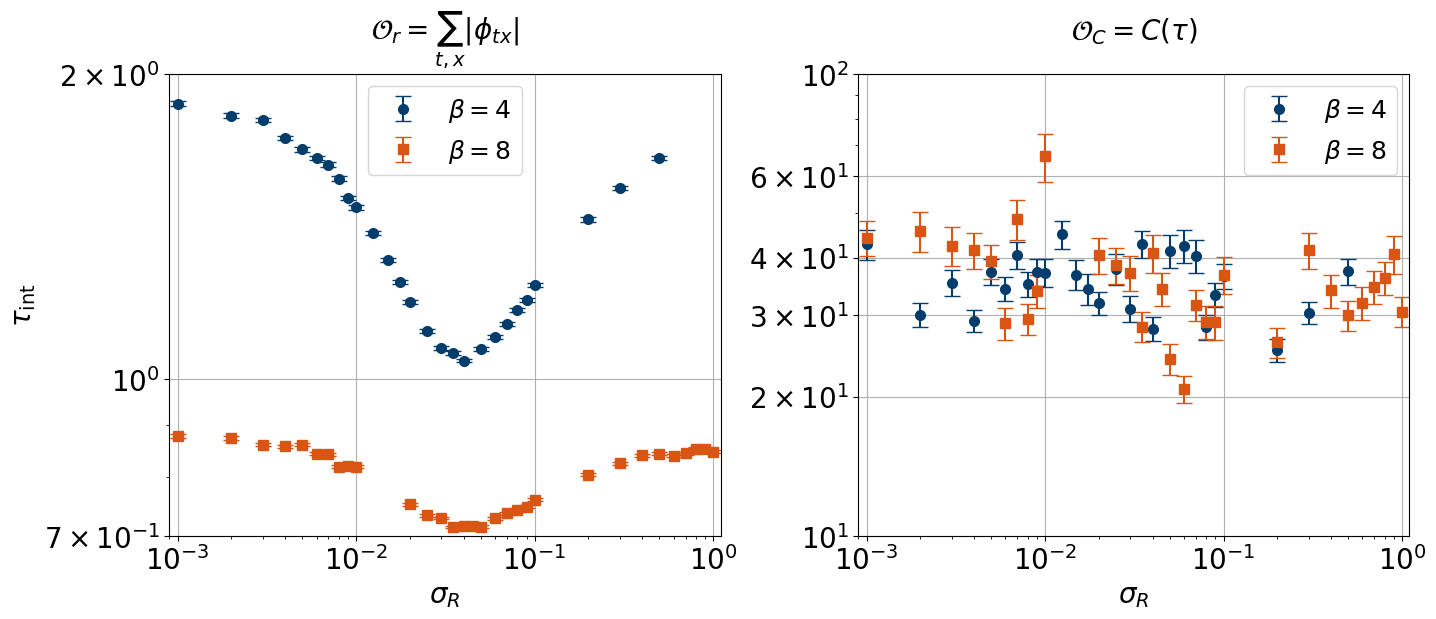

In [34]:
fs = 20
fs2 = 18
marker_ = ["o", "s"]
ms = 7
capsize = 6

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

### Mean of absolute field
cax = ax[0]
cax.set_title(r"$\mathcal{O}_r=\sum_{t,x} |\phi_{tx}|$", fontsize = fs, pad = 25)
for beta_ind, beta in enumerate(beta_):
    Nmd = sim_dict[f"b{beta}"]["Nmd"]
    df = pd.read_csv(postpro_path + f"b{beta}/PeRU_Nt96_Nmd{Nmd}_b{beta}U2_ac_S1_absmean.csv")
    data = df.to_numpy()
    cax.errorbar(data[:, 0], data[:, 5], data[:, 6], color = cs[beta_ind], linestyle = "", marker = marker_[beta_ind], markersize = ms, capsize = capsize, label = r"$\beta = $"+str(beta))

cax.legend(loc = "upper center", fontsize = fs2)


### Correlator
cax = ax[1]
cax.set_title(r"$\mathcal{O}_C = C(\tau)$", fontsize = fs, pad = 25) #\mathrm{max}_\tau \tau_{\mathrm{int}, C(\tau)}
for beta_ind, beta in enumerate(beta_):
    sig_, tint_, dtint_ = np.loadtxt(postpro_path + f"b{beta}/PeRU_b{beta}_corr0_tint_max_ac_zc.txt", usecols = (0, 1, 2), skiprows = 1, unpack = True)
    cax.errorbar(sig_, tint_, dtint_, color = cs[beta_ind], linestyle = "", marker = marker_[beta_ind], markersize = ms, capsize = capsize, label = r"$\beta = $"+str(beta))

cax.legend(loc = "upper right", fontsize = fs2)

for i in range(2):
    ax[i].grid()
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlabel(r"$\sigma_R$", fontsize = fs)
    ax[i].tick_params(axis = "both", which = "minor", labelsize = fs)
    ax[i].tick_params(axis = "both", which = "major", labelsize = fs)
    ax[i].set_xlim(0.0009, 1.1)
    
ax[0].set_ylabel(r"$\tau_{\mathrm{int}}$", fontsize = fs)    
ax[0].set_ylim(0.7, 2)
ax[0].set_yticks([0.7, 1, 2], labels = [r"$7\times 10^{-1}$", r"$10^{0}$", r"$2\times 10^{0}$"], fontsize = fs)

ax[1].set_ylim(10, 100)
ax[1].set_yticks([10, 20, 30, 40, 60, 100], labels = [r"$10^{1}$", r"$2\times 10^{1}$", r"$3\times 10^{1}$", r"$4\times 10^{1}$", r"$6\times 10^{1}$", r"$10^{2}$"], fontsize = fs)

fig.subplots_adjust(wspace = 0.25)
# plt.savefig(plot_path + "PeRU_sig_tint_bcomp_final.pdf", dpi = 300, bbox_inches = "tight")
plt.show()


# Compare correlators between simulations with and without radial updates; DONE

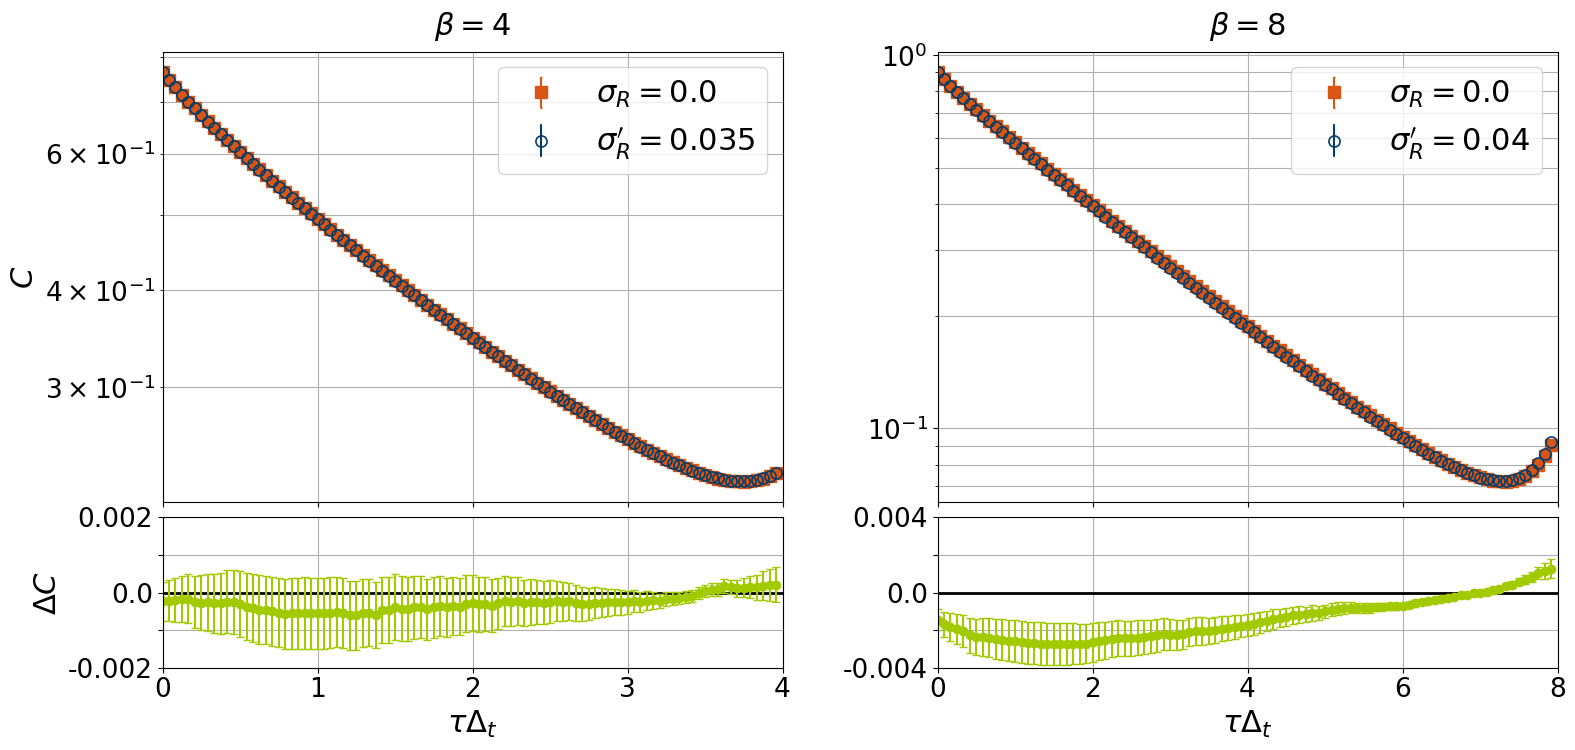

In [90]:
from matplotlib.gridspec import GridSpec

sig1 = 0.0 # Simulation without radial updates
    
beta = 4
sig2 = 0.035 # Simulation with radial updates
corr_ind = 1 # Which correlator; either 0 or 1
fname = postpro_path + f"b{beta}/PeRU_s"+str(sig1).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_zc.txt"
corr1, err1 = np.loadtxt(fname, usecols = (0, 1), skiprows = 1, unpack  = True)

fname = postpro_path + f"b{beta}/PeRU_s"+str(sig2).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_zc.txt"
corr1_ru, err1_ru = np.loadtxt(fname, usecols = (0, 1), skiprows = 1, unpack  = True)

x = np.arange(0, 96, 1)*beta/96
tmp_x = [0.0, 1.0, 2.0, 3.0, 4.0]

fs = 22
fs2 = 19
ms = 8

fig = plt.figure(figsize = (18,8))
gs = GridSpec(2, 2, height_ratios = [3,1], width_ratios = [1,1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex = ax1)
ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1,1], sharex = ax3)
    
    
cax = ax1#ax[0,0]
cax.errorbar(x, corr1, err1, color = cs[1], linestyle = "", marker = "s", markersize = ms, capsize = 1, label = rf"$\sigma_R = {sig1}$")
cax.errorbar(x, corr1_ru, err1_ru, color = cs[0], alpha = 1.0, linestyle = "", mew = 1.2, marker = "o", fillstyle = "none", markersize = ms, capsize = 1, label = rf"$\sigma_R' = {sig2}$")
cax.set_yscale("log")
cax.grid(which = "both")
cax.tick_params(which = "both", labelsize = fs2)
cax.tick_params(axis = "x", labelbottom = False)
cax.set_xlim(0, beta)
cax.set_ylabel(r"$C$", fontsize = fs)
cax.legend(fontsize = fs)
# cax.spines["bottom"].set_linewidth(2)
cax.set_title(r"$\beta =$"+str(beta), fontsize = fs, pad = 12)

cax = ax2#ax[1,0]
cax.axhline(0.0, color = "k", linewidth = "2")
delta_corr1 = np.subtract(corr1_ru, corr1)
err_delta_corr1 = np.sqrt(np.add(np.power(err1_ru, 2), np.power(err1, 2)))
cax.errorbar(x, delta_corr1, err_delta_corr1, marker = "o", color = cs[2], linestyle = "", capsize = 3)
cax.grid()
cax.set_yticks([-0.002, -0.001, 0.0, 0.001, 0.002], labels = ["-0.002", "", "0.0", "", "0.002"], fontsize = fs2)
cax.set_xticks(tmp_x, labels = ["0", "1", "2", "3", "4"], fontsize = fs2)
cax.set_ylabel(r"$\Delta C$", fontsize = fs)
cax.set_xlabel(r"$\tau\Delta_t$", fontsize = fs)


beta = 8
sig2 = 0.04
corr_ind = 1
fname = postpro_path + f"b{beta}/PeRU_s"+str(sig1).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_zc.txt"
corr1, err1 = np.loadtxt(fname, usecols = (0, 1), skiprows = 1, unpack  = True)

fname = postpro_path + f"b{beta}/PeRU_s"+str(sig2).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_zc.txt"
corr1_ru, err1_ru = np.loadtxt(fname, usecols = (0, 1), skiprows = 1, unpack  = True)

x = np.arange(0, 96, 1)*beta/96
tmp_x = [0.0, 2.0, 4.0, 6.0, 8.0]

cax = ax3#ax[0,1]
cax.errorbar(x, corr1, err1, color = cs[1], linestyle = "", marker = "s", markersize = ms+1, capsize = 1, label = rf"$\sigma_R = {sig1}$")
cax.errorbar(x, corr1_ru, err1_ru, color = cs[0], alpha = 1.0, linestyle = "", mew = 1.2, marker = "o", fillstyle = "none", markersize = ms, capsize = 1, label = rf"$\sigma_R' = {sig2}$")
cax.set_yscale("log")
cax.grid(which = "both")
cax.legend(fontsize = fs)
cax.tick_params(axis = "x", labelbottom = False)
cax.tick_params(axis = "y", which = "both", labelsize = fs2)
cax.set_xlim(0, beta)
# cax.set_ylim(0.22, 0.8)
# cax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0], labels = ["0", "1", "2", "3", "4"], fontsize = fs)
cax.set_title(r"$\beta =$"+str(beta), fontsize = fs, pad = 12)

cax = ax4#ax[1,1]
cax.axhline(0.0, color = "k", linewidth = "2")
delta_corr1 = np.subtract(corr1_ru, corr1)
err_delta_corr1 = np.sqrt(np.add(np.power(err1_ru, 2), np.power(err1, 2)))
cax.errorbar(x, delta_corr1, err_delta_corr1, marker = "o", color = cs[2], linestyle = "", capsize = 3)
cax.grid()
cax.set_yticks([-0.004, -0.002, 0.0, 0.002, 0.004], labels = ["-0.004", "", "0.0", "", "0.004"], fontsize = fs2)
cax.set_xticks(tmp_x, labels = ["0", "2", "4", "6", "8"], fontsize = fs2)
# cax.set_ylabel(r"$\Delta C(\tau)$", fontsize = fs)
cax.set_xlabel(r"$\tau\Delta_t$", fontsize = fs)
cax.set_ylim(-0.004, 0.004)

fig.subplots_adjust(wspace = 0.25, hspace = 0.05)
# plt.savefig(plot_path + f"C+_correlator_comparison.pdf", dpi = 300, bbox_inches = "tight")
plt.show()




Comparison of all simulations. DONE

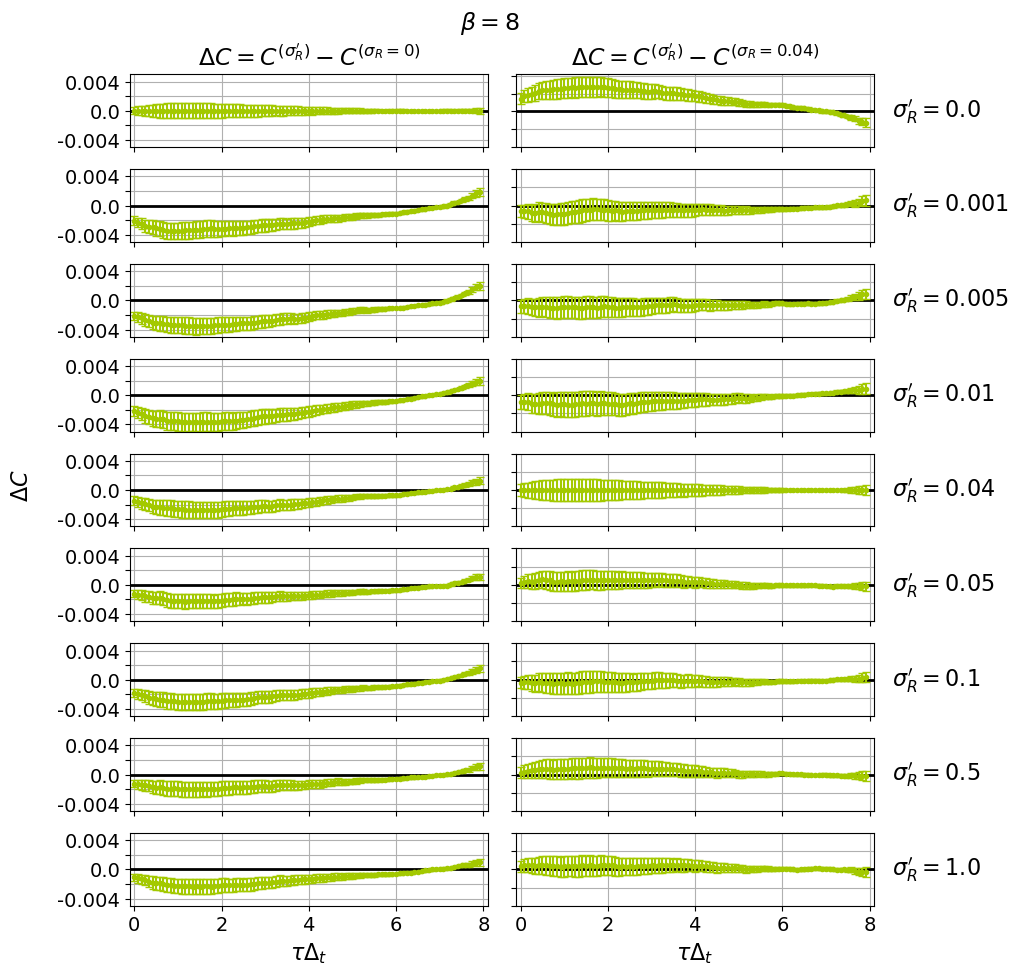

In [106]:
from matplotlib.gridspec import GridSpec

sig1 = 0.0
sig1b = 0.04
beta = 8

if beta==8:
    sig2_ = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    sig2_ = [0.0, 0.001, 0.005, 0.01, 0.04, 0.05, 0.1, 0.5, 1.0] #reduced number of standard deviations
elif beta == 4:
    sig2_ = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.5]
    sig2_ = [0.0, 0.001, 0.002, 0.005, 0.008, 0.01, 0.02, 0.03, 0.035, 0.04, 0.05, 0.08, 0.1, 0.3, 0.5] #reduced number of standard deviations

corr_ind = 1
fname = postpro_path + f"b{beta}/PeRU_s"+str(sig1).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_zc.txt"
corr1, err1, tint1, dtint1, W1 = np.loadtxt(fname, usecols = (0, 1, 2, 3, 4), skiprows = 1, unpack  = True)
fname = postpro_path + f"b{beta}/PeRU_s"+str(sig1b).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_zc.txt"
corr1b, err1b, tint1, dtint1, W1 = np.loadtxt(fname, usecols = (0, 1, 2, 3, 4), skiprows = 1, unpack  = True)

n_rows = 2
n_cols = len(sig2_)
fig, ax = plt.subplots(n_cols, n_rows, figsize = (n_rows * 4.8, n_cols * 1.2), sharex = True, sharey = False)
fs = 16
fs2 = 14
ms = 4
x = np.arange(0, 96, 1)*beta/96
Delta_x = beta/4
tmp_x = [0*Delta_x, 1*Delta_x, 2*Delta_x, 3*Delta_x, 4*Delta_x]
tmp_x_labels = [str(x) for x in tmp_x]
tmp_x_labels = ["0", "2", "4", "6", "8"]
ylim = 0.005
yticks = [-0.004, -0.002, 0.0, 0.002, 0.004]
ytick_labels = ["-0.004", "", "0.0", "", "0.004"]
for i, sig2 in enumerate(sig2_):
    fname = postpro_path + f"b{beta}/PeRU_s"+str(sig2).replace(".", "p")+f"_b{beta}U2_corr{corr_ind}_ac_zc.txt"
    corr1_ru, err1_ru, tint2, dtint2, W2 = np.loadtxt(fname, usecols = (0, 1, 2, 3, 4), skiprows = 1, unpack  = True)

    cax = ax[i, 0]
    cax.axhline(0.0, color = "k", linewidth = "2")
    delta_corr1 = np.subtract(corr1_ru, corr1)
    err_delta_corr1 = np.sqrt(np.add(np.power(err1_ru, 2), np.power(err1, 2)))
    cax.errorbar(x, delta_corr1, err_delta_corr1, marker = "o", markersize = 3, color = cs[2], linestyle = "", capsize = 3, label = r"$\sigma_R'=$"+str(sig2))
    cax.grid()
    cax.set_yticks(yticks, labels = ytick_labels, fontsize = fs2)
    # cax.set_yticks(yticks, labels = ytick_labels if i==0 else ["" for x in yticks], fontsize = fs)
    cax.set_xticks(tmp_x, labels = tmp_x_labels, fontsize = fs2)
    
    # cax.set_ylabel(r"$\Delta C(\tau)$", fontsize = fs)
    # cax.legend(loc = "upper left")
    cax.set_ylim(-ylim, ylim)
    cax.set_xlim(-0.1, 8.1)
    
    cax = ax[i, 1]
    cax.axhline(0.0, color = "k", linewidth = "2")
    delta_corr1 = np.subtract(corr1_ru, corr1b)
    err_delta_corr1 = np.sqrt(np.add(np.power(err1_ru, 2), np.power(err1b, 2)))
    cax.errorbar(x, delta_corr1, err_delta_corr1, marker = "o", markersize = 3, color = cs[2], linestyle = "", capsize = 3, label = r"$\sigma_R'=$"+str(sig2))
    cax.grid()
    cax.set_xticks(tmp_x, labels = tmp_x_labels, fontsize = fs2)
    cax.set_yticks(yticks, labels = ["" for x in yticks], fontsize = fs2)
    # cax.legend(loc = "upper right")
    cax.text(1.05, 0.5, r"$\sigma_R'=$"+str(sig2), transform=cax.transAxes, fontsize = fs, va = "center", ha = "left", rotation = 0)
    cax.set_xlim(-0.1, 8.1)
    
fig.suptitle(r"$\beta =$"+str(beta), fontsize = fs+1, y = 0.94, x = 0.5)
# plt.savefig("b4_correlator_comparison_prelim.png", dpi = 300, bbox_inches = "tight")
ax[-1, 0].set_xlabel(r"$\tau\Delta_t$", fontsize = fs)
ax[-1, 1].set_xlabel(r"$\tau\Delta_t$", fontsize = fs)
ax[0, 0].set_title(r"$\Delta C = C^{(\sigma_R')}-C^{(\sigma_R=0)}$", fontsize = fs+1)
ax[0, 1].set_title(r"$\Delta C = C^{(\sigma_R')}-C^{(\sigma_R=0.04)}$", fontsize = fs+1)
fig.supylabel(r"$\Delta C$", fontsize = fs, x = 0.0)
fig.subplots_adjust(wspace = 0.08, hspace = 0.3)
# plt.savefig(plot_path + f"reduced_DeltaC_comparison_beta{beta}.pdf", dpi = 300, bbox_inches = "tight")
plt.show()
